In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1423


In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

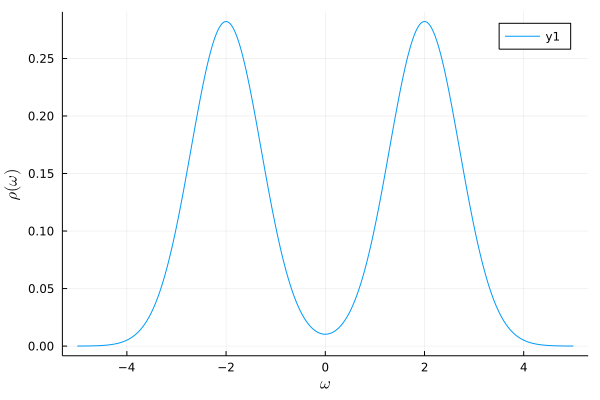

In [80]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.3)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
#rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
rho(omega) = 0.5*gaussian(omega, -2.0, 1.0) + 0.5*gaussian(omega, 2.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [81]:
setprecision(512)
;

In [82]:
beta = 100
wmax = 100
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;

In [83]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [84]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

52

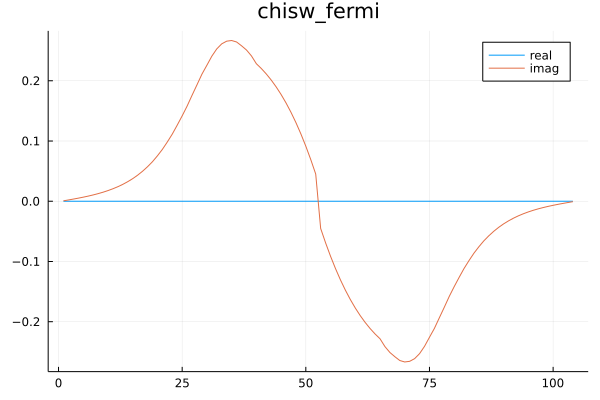

In [85]:
plot(title="chisw_fermi")
plot!(real.(gw[:]), label="real")
plot!(imag.(gw[:]), label="imag")

In [86]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

1.0

In [87]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [88]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [89]:
N_real    =  1000
omega_max =  10.0
N_eta     =  10
eta_max   =  0.1
eta_min   =  0.01
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 15
println("N_imp $(N_imag)")
;

N_imag is setted as 32
N_imp 32


In [96]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta_max, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.972158e-02     5.980607e-05
 * time: 4.482269287109375e-5
     1     1.954086e-02     8.865809e-03
 * time: 1.9884347915649414
     2     1.949347e-02     3.931710e-04
 * time: 3.2519168853759766
     3     1.942630e-02     3.360086e-04
 * time: 3.815297842025757
     4     1.939478e-02     2.721559e-04
 * time: 4.807747840881348
     5     1.939447e-02     2.002958e-04
 * time: 5.08319091796875
     6     1.939437e-02     2.378315e-04
 * time: 5.333636999130249
     7     1.939367e-02     2.072465e-04
 * time: 5.692603826522827
     8     1.939276e-02     2.885756e-04
 * time: 5.975766897201538
     9     1.939171e-02     2.097716e-04
 * time: 6.264053821563721
    10     1.938900e-02     2.658043e-04
 * time: 6.543028831481934
    11     1.938769e-02     1.305587e-04
 * time: 6.702997922897339
    12     1.938702e-02     3.019462e-05
 * time: 6.881044864654541
    13     1.938639e-02     

    76     1.506977e-02     1.813949e-03
 * time: 28.297175884246826
    77     1.506926e-02     2.177415e-03
 * time: 28.502627849578857
    78     1.506871e-02     1.928480e-03
 * time: 28.713677883148193
    79     1.506813e-02     2.463637e-03
 * time: 28.91123390197754
    80     1.506747e-02     1.936847e-03
 * time: 29.108982801437378
    81     1.506678e-02     2.769765e-03
 * time: 29.316840887069702
    82     1.506594e-02     1.800371e-03
 * time: 29.521958827972412
    83     1.506508e-02     3.155784e-03
 * time: 29.72036385536194
    84     1.506389e-02     1.522142e-03
 * time: 29.928566932678223
    85     1.506267e-02     3.853095e-03
 * time: 30.125356912612915
    86     1.506059e-02     1.451990e-03
 * time: 30.330529928207397
    87     1.505862e-02     5.641887e-03
 * time: 30.541839838027954
    88     1.505313e-02     3.430675e-03
 * time: 30.739662885665894
    89     1.504959e-02     9.963845e-03
 * time: 30.93714690208435
    90     1.503367e-02     7.422499e

   196     1.253028e-02     5.269266e-02
 * time: 63.5467848777771
   197     1.251963e-02     4.785044e-02
 * time: 63.7524528503418
   198     1.247880e-02     4.231604e-02
 * time: 64.04814195632935
   199     1.246876e-02     4.475922e-02
 * time: 64.25590682029724
   200     1.245741e-02     1.933492e-02
 * time: 64.55766797065735
   201     1.245192e-02     1.104306e-02
 * time: 64.76241397857666
   202     1.244672e-02     1.313057e-02
 * time: 65.07340884208679
   203     1.244273e-02     1.399434e-02
 * time: 65.26745891571045
   204     1.243510e-02     1.580905e-02
 * time: 65.58067488670349
   205     1.242705e-02     2.496884e-02
 * time: 65.78613877296448
   206     1.242019e-02     2.180337e-02
 * time: 65.98538899421692
   207     1.241598e-02     2.278128e-02
 * time: 66.3902440071106
   208     1.241171e-02     2.321425e-02
 * time: 66.59642100334167
   209     1.240524e-02     2.385727e-02
 * time: 66.99456787109375
   210     1.240008e-02     2.318144e-02
 * time: 6

    47     1.414952e-02     9.644329e-02
 * time: 25.835504055023193
    48     1.403246e-02     2.236955e-02
 * time: 26.070213079452515
    49     1.398064e-02     4.018507e-02
 * time: 26.401215076446533
    50     1.395614e-02     3.737016e-02
 * time: 26.737215995788574
    51     1.393692e-02     3.868936e-02
 * time: 26.962440967559814
    52     1.390288e-02     2.213067e-02
 * time: 27.294660091400146
    53     1.387526e-02     2.364052e-02
 * time: 27.530694007873535
    54     1.383183e-02     7.827562e-03
 * time: 27.744729042053223
    55     1.373636e-02     2.633281e-02
 * time: 28.080708980560303
    56     1.371244e-02     3.435972e-02
 * time: 28.419316053390503
    57     1.370509e-02     3.094180e-02
 * time: 28.64413809776306
    58     1.367493e-02     3.064125e-02
 * time: 28.973225116729736
    59     1.365134e-02     2.971274e-02
 * time: 29.20780110359192
    60     1.360772e-02     6.891777e-02
 * time: 29.426517963409424
    61     1.359968e-02     5.597500

   168     1.058344e-02     1.421753e-03
 * time: 67.68639206886292
   169     1.058334e-02     1.272542e-03
 * time: 67.91316294670105
   170     1.058326e-02     1.294681e-03
 * time: 68.13926696777344
   171     1.058319e-02     1.125486e-03
 * time: 68.36309909820557
   172     1.058312e-02     1.045923e-03
 * time: 68.58871507644653
   173     1.058307e-02     1.073029e-03
 * time: 68.81244993209839
   174     1.058302e-02     8.816285e-04
 * time: 69.03118705749512
   175     1.058297e-02     1.015517e-03
 * time: 69.26519513130188
   176     1.058293e-02     6.933233e-04
 * time: 69.48364496231079
   177     1.058290e-02     8.888535e-04
 * time: 69.70942711830139
   178     1.058287e-02     5.138240e-04
 * time: 69.93377614021301
   179     1.058284e-02     7.202922e-04
 * time: 70.15990400314331
   180     1.058281e-02     4.601990e-04
 * time: 70.38373303413391
   181     1.058278e-02     5.747940e-04
 * time: 70.60337805747986
   182     1.058276e-02     4.210014e-04
 * time

LoadError: InterruptException:

In [97]:
@time Nevanlinna.solve!(sol)

H=11
Iter     Function value   Gradient norm 
     0     3.736933e-05     9.491146e-06
 * time: 0.0002079010009765625
     1     3.735048e-05     2.866919e-06
 * time: 1.0341949462890625
     2     3.734785e-05     1.155112e-06
 * time: 2.296376943588257
     3     3.734783e-05     1.179080e-06
 * time: 2.9157350063323975
     4     3.734699e-05     7.384982e-07
 * time: 4.134569883346558
     5     3.734691e-05     6.944227e-07
 * time: 5.1844048500061035
     6     3.734608e-05     3.410823e-07
 * time: 5.992657899856567
     7     3.734590e-05     3.175263e-07
 * time: 7.443770885467529
     8     3.734585e-05     1.818803e-07
 * time: 8.059839010238647
     9     3.734569e-05     1.264067e-07
 * time: 9.491780042648315
    10     3.734568e-05     8.862856e-08
 * time: 10.109576940536499
    11     3.734562e-05     7.034117e-08
 * time: 11.552640914916992
    12     3.734561e-05     5.743972e-08
 * time: 12.180311918258667
    13     3.734560e-05     7.524672e-08
 * time: 13.6289589

LoadError: InterruptException:

In [77]:
eta_arr = eta_max .- collect(1:N_eta)*((eta_max-eta_min)/(N_eta))
eta_arr[N_eta] = eta_min
;

In [78]:
for ieta = 1:N_eta
    eta_curr  = eta_arr[ieta]
    sol.reals = Nevanlinna.RealDomainData(sol.reals.N_real, sol.reals.omega_max, eta_curr, sol.reals.sum, T=T)
    sol.abcd  = Nevanlinna.calc_abcd(sol.imags, sol.reals, sol.phis)
    sol.H_min = sol.H
    sol.hardy_matrix .= Nevanlinna.calc_hardy_matrix(sol.reals, sol.H_min)
    println("current eta is $(eta_curr)")
    @time Nevanlinna.solve!(sol)
    if isdefined(Main, :IJulia)
        Main.IJulia.stdio_bytes[] = 0
    end
end

current eta is 0.091
H=11
Iter     Function value   Gradient norm 
     0     3.736933e-05     9.491146e-06
 * time: 0.00019693374633789062
     1     3.735048e-05     2.866919e-06
 * time: 1.1612319946289062


LoadError: InterruptException:

In [94]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta_min, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


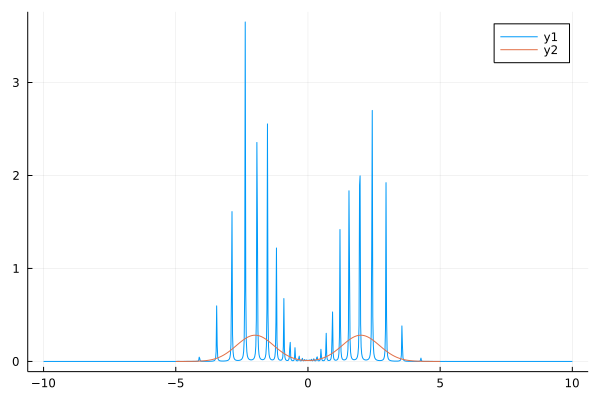

In [95]:
plot(real.(raw_reals.freq), imag.(raw_reals.val)/pi)
plot!(omegas, rho.(omegas))

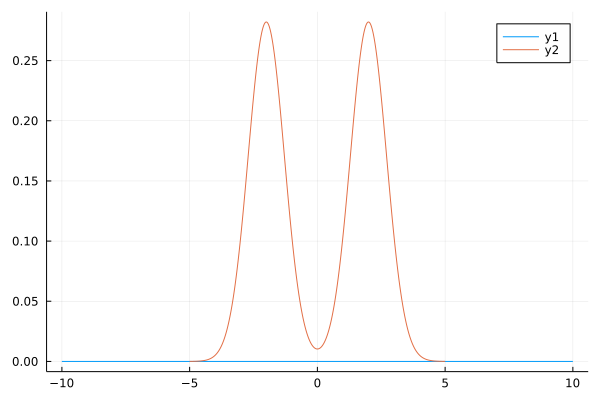

In [99]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [37]:
imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
#noopt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#opt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#noopt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
#opt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
noopt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
opt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
noopt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
opt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, noopt_raw_reals, phis)
ab_coeff  = zeros(ComplexF64, 2*sol.H) 
hardy_matrix = Nevanlinna.calc_hardy_matrix(noopt_raw_reals, sol.H)

Nevanlinna.evaluation!(noopt_raw_reals, abcd, sol.H, ab_coeff, hardy_matrix)
Nevanlinna.evaluation!(opt_raw_reals, abcd, sol.H, sol.ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.


LoadError: MethodError: no method matching RealDomainData(::Int64, ::Float64, ::Float64; T=BigFloat)
[0mClosest candidates are:
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m; T, small_omega, mesh) at ~/work/Nevanlinna/src/data.jl:55
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m, [91m::Array{Complex{T}, 1}[39m, [91m::Array{Complex{T}, 1}[39m) where T<:Real at ~/work/Nevanlinna/src/data.jl:47[91m got unsupported keyword argument "T"[39m

In [38]:
using FastGaussQuadrature
using OMEinsum
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_green_z(z::Vector{ComplexF64}, xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    newaxis = [CartesianIndex()]
    green_z = ein"q,q,wq->w"(
            quad_rule[2],
            rho.(quad_rule[1]),
            1 ./ (z[:, newaxis] .- quad_rule[1][newaxis, :])
        )
    return green_z
end
#exact_g = calc_green_z(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag])*im*pi/beta, -omega_max, omega_max, 1000)
exact_g = calc_green_z(((collect(1:200).-100)/1000000)*2*pi*im/beta, -omega_max, omega_max, 1000000)

;

LoadError: ArgumentError: Package FastGaussQuadrature not found in current path:
- Run `import Pkg; Pkg.add("FastGaussQuadrature")` to install the FastGaussQuadrature package.


In [39]:
using FastGaussQuadrature
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_sum_omega(xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    sum_omega = 0.0
    for i in 1:deg
        sum_omega += (quad_rule[2] .* rho.(quad_rule[1]))[i]
    end

    return sum_omega
end
sum_o = calc_sum_omega(-omega_max, omega_max, 1000)

LoadError: ArgumentError: Package FastGaussQuadrature not found in current path:
- Run `import Pkg; Pkg.add("FastGaussQuadrature")` to install the FastGaussQuadrature package.


In [40]:
exact_g[11]

LoadError: UndefVarError: exact_g not defined

In [41]:
plot()
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(exact_g)), xlim=[0,0.3],label="real_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-opt_raw_reals.val)), label="real_nopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(exact_g)), xlim=[0,0.01],label="imag_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-opt_raw_reals.val)), label="imag_nopt_dense")

LoadError: UndefVarError: exact_g not defined

In [42]:
plot()
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-noopt_raw_reals.val-exact_g)), xlim = [0,0.01], label="real_nonopt_dense", xlabel=latexstring("\\omega"), ylabel=latexstring("|\\Delta G(i\\omega_\\nu)|"), yaxis=:log)
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-opt_raw_reals.val-exact_g)), label="real_opt_dense")

LoadError: UndefVarError: noopt_raw_reals not defined

In [43]:
#plot()
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(exact_g)), label="real_exact", xlabel=latexstring("\\nu"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-opt_raw_reals.val)), label="real_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(real.(test_gw[1:N_imag])), label="real_sparse")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(exact_g)), label="imag_exact")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-opt_raw_reals.val)), label="imag_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(imag.(test_gw[1:N_imag])), label="imag_sparse")

In [25]:
#plot()
#plot(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-noopt_raw_reals.val.-exact_g)), yaxis=:log, label="abs_nonopt_dense", xlabel=latexstring("\\nu"), ylabel=latexstring("\\Delta |G(i\\omega_\\nu)|"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-opt_raw_reals.val-exact_g)), label="abs_opt_dense")

In [26]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [27]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#